In [295]:
#|export
from tsai.imports import *
from tsai.models.layers import *
from torchinfo import summary

In [296]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import signal

In [297]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [345]:
# hyper parameter
num_classes = 30
batch_size = 64
learning_rate = 0.001
num_epochs = 10
down_ratio = 8
sequence_len = 2000 * 5 // down_ratio # default 2000Hz
overlap = int(sequence_len * 0.3)
threshold = 0.85
Unknown_label = 15

In [299]:
radar_frame_list = []
scaler = MinMaxScaler((-1, 1)) # or StandardScaler

for i in range(1, num_classes + 1):
    # wave_2d = [] # input need to be 2d?
    file_path = "./data/radar_%02d.csv" % i # or ./data/radar_%02d
    radar_frame = pd.read_csv(file_path)
    wave = radar_frame.to_numpy().flatten()
    wave = signal.decimate(wave, down_ratio) # down sampling
    
    end = len(wave)
    n = 0
    n_stop = sequence_len
    wave_segments = []

    while n_stop < end:
        n_start = 0 + ((sequence_len - 1) - (overlap - 1)) * n
        n_stop = n_start + sequence_len
        tmp = []
        seg = wave[n_start:n_stop].copy()
        wave_segments.append([seg])
        n += 1
    
    radar_frame_list.append(wave_segments)

data_df = pd.DataFrame(radar_frame_list)

In [300]:
labels = []
for i in range(len(radar_frame_list)):
    for j in range(len(radar_frame_list[i])):
        if i <= 14:
            labels.append(i)
        else:
            labels.append(15)

labels_series = pd.Series(labels)

In [301]:
tmp = data_df.to_numpy().flatten().copy()
data_series = pd.Series(tmp).dropna() # remove None (keys are as they are)
tmp = data_series.to_numpy().flatten()

tmp_labels = labels_series.to_numpy().flatten()
# len(tmp) = 5442 (30人分のデータ)
# len(tmp[0]) = 1 (in_channelが1のため)
# len(tmp[0][0]) = 1250 (sequence_len)

for i in reversed(range(len(tmp))):
  if len(tmp[i][0]) != sequence_len:
    print(i, len(tmp[i][0]))
    tmp = np.delete(tmp, i)
    tmp_labels = np.delete(tmp_labels, i)

data_series = pd.Series(tmp)
labels_series = pd.Series(tmp_labels)
labels_tensor = torch.tensor(labels_series)
data_series.shape, labels_tensor, labels_tensor.shape

5441 900
5262 838
5086 725
4911 1219
4732 507
4497 1107
4321 1244
4147 838
3953 438
3764 1232
3589 788
3406 1150
3234 619
3052 1188
2880 388
2705 1113
2348 1157
2141 1113
1956 1232
1771 532
1588 475
1402 644
1225 1232
1044 482
869 1150
695 1144
523 713
351 713
173 525


((5413,), tensor([ 0,  0,  0,  ..., 15, 15, 15]), torch.Size([5413]))

In [302]:
class InceptionModule(Module):
    def __init__(self, ni, nf, ks=40, bottleneck=True):
        ks = [ks // (2**i) for i in range(3)]
        ks = [k if k % 2 != 0 else k - 1 for k in ks]  # ensure odd ks
        bottleneck = bottleneck if ni > 1 else False
        self.bottleneck = Conv1d(ni, nf, 1, bias=False) if bottleneck else noop
        self.convs = nn.ModuleList([Conv1d(nf if bottleneck else ni, nf, k, bias=False) for k in ks])
        self.maxconvpool = nn.Sequential(*[nn.MaxPool1d(3, stride=1, padding=1), Conv1d(ni, nf, 1, bias=False)])
        self.concat = Concat()
        self.bn = BN1d(nf * 4)
        self.act = nn.ReLU()

    def forward(self, x):
        input_tensor = x
        x = self.bottleneck(input_tensor)
        x = self.concat([l(x) for l in self.convs] + [self.maxconvpool(input_tensor)])
        return self.act(self.bn(x))


@delegates(InceptionModule.__init__)
class InceptionBlock(Module):
    def __init__(self, ni, nf=32, residual=True, depth=6, **kwargs):
        self.residual, self.depth = residual, depth
        self.inception, self.shortcut = nn.ModuleList(), nn.ModuleList()
        for d in range(depth):
            self.inception.append(InceptionModule(ni if d == 0 else nf * 4, nf, **kwargs))
            if self.residual and d % 3 == 2: 
                n_in, n_out = ni if d == 2 else nf * 4, nf * 4
                self.shortcut.append(BN1d(n_in) if n_in == n_out else ConvBlock(n_in, n_out, 1, act=None))
        self.add = Add()
        self.act = nn.ReLU()
        
    def forward(self, x):
        res = x
        for d, l in enumerate(range(self.depth)):
            x = self.inception[d](x)
            if self.residual and d % 3 == 2: res = x = self.act(self.add(x, self.shortcut[d//3](res)))
        return x

    
@delegates(InceptionModule.__init__)
class InceptionTime(Module):
    def __init__(self, c_in, c_out, seq_len=None, nf=32, nb_filters=None, **kwargs):
        nf = ifnone(nf, nb_filters) # for compatibility
        self.inceptionblock = InceptionBlock(c_in, nf, **kwargs) # c_in is input channel num of conv1d
        self.gap = GAP1d(1)
        self.fc = nn.Linear(nf * 4, c_out) # c_out is 1d output size 

    def forward(self, x):
        x = self.inceptionblock(x)
        x = self.gap(x)
        x = self.fc(x)
        return x

In [303]:
from tsai.models.utils import count_parameters

In [304]:
class MyDataset(Dataset):
    def __init__(self, dataset, labels, root_dir, transform=None) -> None:
        # super().__init__()
        self.radar_heartbeat = dataset
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()
        
        onehot_label = torch.eye(num_classes)[self.labels[idx] - 1] # one hot encodingは不要らしい　精度悪い場合試す必要あり
        # one_hot = torch.nn.functional.one_hot(self.labels, num_classes=num_classes)
        return torch.tensor(self.radar_heartbeat[idx]), self.labels[idx] # labels is already tensor (converted in preparation phase)
        # return torch.tensor(self.radar_heartbeat[idx]), onehot_label

    def __len__(self):
        return len(self.radar_heartbeat)


dataset = MyDataset(data_series, labels_tensor, "./data/", transform=transforms.ToTensor())

In [305]:
dataset[0][1], dataset[4473][1], dataset[4474][1], dataset[len(dataset)-1][1]

(tensor(0), tensor(15), tensor(15), tensor(15))

In [306]:
dataset[3570][1], dataset[3571][1]

(tensor(15), tensor(15))

In [307]:
dataset[2691][1], dataset[2692][1]

(tensor(14), tensor(15))

Additional processing for Open Set

e.g.
train 0~24

test 0~30

concat

In [308]:
# indices1 = np.arange(4473)
# dataset1 = torch.utils.data.Subset(dataset, indices1) # 0-24
# indices2 = np.arange(4474, len(dataset))
# dataset2 = torch.utils.data.Subset(dataset, indices2) # 25-30

In [309]:
# indices1 = np.arange(3570)
# dataset1 = torch.utils.data.Subset(dataset, indices1) # 0-19
# indices2 = np.arange(3571, len(dataset))
# dataset2 = torch.utils.data.Subset(dataset, indices2) # 20-30

In [310]:
indices1 = np.arange(2691)
dataset1 = torch.utils.data.Subset(dataset, indices1) # 0-14
indices2 = np.arange(2692, len(dataset))
dataset2 = torch.utils.data.Subset(dataset, indices2) # 15-29

In [311]:
train_size1 = int(0.8 * len(dataset1))
test_size1 = len(dataset1) - train_size1

train_size2 = int(0.8 * len(dataset2))
test_size2 = len(dataset2) - train_size2

open_train_set, test_set1 = torch.utils.data.random_split(dataset1, [train_size1, test_size1])
train_set2, test_set2 = torch.utils.data.random_split(dataset2, [train_size2, test_size2])

train : test = 8 : 2で分ける？

でもtrainの数変わらないからtestは多くても変わらない気がする

In [312]:
open_test_set = torch.utils.data.ConcatDataset([test_set1, test_set2])
len(open_train_set), len(open_test_set)

(2152, 1084)

In [313]:
train_size = int(0.8 * len(data_series.values))
test_size = len(data_series.values) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size]) # check whether each data and label set is synchronized 
print(f"full: {len(dataset)} -> train: {len(train_set)}, test: {len(test_set)}")

train_loader = DataLoader(dataset=open_train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=open_test_set, batch_size=batch_size, shuffle=False)

full: 5413 -> train: 4330, test: 1083


In [314]:
model = InceptionTime(1, num_classes - 5 + 1) # 0-24, Unknown(25)を出力, 2
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [315]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (signals, labels) in enumerate(train_loader):
    signals = torch.tensor(signals)
    signals = signals.float()
    signals = signals.to(device)
    labels = labels.to(device)

    # print(signals.size())
    outputs = model(signals)
    # print(outputs)
    loss = criterion(outputs, labels) # will check the shapes of outputs and labels

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i + 1) % 12 == 0:
      print(f'Epoch [{epoch+1}/`{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

/tmp/ipykernel_2316/238323891.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)


Epoch [1/`10], Step [12/34], Loss: 2.3889
Epoch [1/`10], Step [24/34], Loss: 2.0269
Epoch [2/`10], Step [12/34], Loss: 1.5774
Epoch [2/`10], Step [24/34], Loss: 1.3474
Epoch [3/`10], Step [12/34], Loss: 1.0221
Epoch [3/`10], Step [24/34], Loss: 0.8778
Epoch [4/`10], Step [12/34], Loss: 0.7034
Epoch [4/`10], Step [24/34], Loss: 0.4621
Epoch [5/`10], Step [12/34], Loss: 0.3869
Epoch [5/`10], Step [24/34], Loss: 0.3267
Epoch [6/`10], Step [12/34], Loss: 0.3511
Epoch [6/`10], Step [24/34], Loss: 0.2182
Epoch [7/`10], Step [12/34], Loss: 0.1956
Epoch [7/`10], Step [24/34], Loss: 0.2019
Epoch [8/`10], Step [12/34], Loss: 0.0895
Epoch [8/`10], Step [24/34], Loss: 0.0896
Epoch [9/`10], Step [12/34], Loss: 0.0738
Epoch [9/`10], Step [24/34], Loss: 0.0745
Epoch [10/`10], Step [12/34], Loss: 0.0642
Epoch [10/`10], Step [24/34], Loss: 0.0535


labelは0-24までだから，学習はいじらなくて大丈夫

testはOpen setの場合，0~24とUnknown label(25)になるから，labelは作り直し

25も出力するようなネットワークにしなきゃだめ

In [346]:
# For Confusion Matrix
predicted_lists = np.zeros(0, dtype=np.int64)
one_hot_labels_list = np.zeros(0, dtype=np.int64)

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  softmax = nn.Softmax()
  for i, (signals, one_hot_labels) in enumerate(test_loader):
    signals = torch.tensor(signals)
    signals = signals.float()
    signals = signals.to(device)
    one_hot_labels = one_hot_labels.to(device)
    # print(len(one_hot_labels))
    outputs = model(signals)
    for j, out in enumerate(outputs):
      outputs[j] = softmax(out)

    _, predicted = torch.max(outputs.data, 1) # predicted per batch size
    
    for idx in range(len(_)):
      if _[idx] < threshold:
        predicted[idx] = Unknown_label # 25

    n_samples += one_hot_labels.size(0) # add batch_size
    n_correct += (predicted == one_hot_labels).sum().item()
    
    predicted_cp = predicted.to('cpu').detach().numpy().copy()
    one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
    predicted_lists = np.concatenate([predicted_lists, predicted_cp])
    one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
    
    acc = 100.0 * n_correct / n_samples
    print(f'{n_correct} / {n_samples} = Acc: {acc} %')

/tmp/ipykernel_2316/2063505040.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)


61 / 64 = Acc: 95.3125 %
117 / 128 = Acc: 91.40625 %
175 / 192 = Acc: 91.14583333333333 %
231 / 256 = Acc: 90.234375 %
289 / 320 = Acc: 90.3125 %
347 / 384 = Acc: 90.36458333333333 %
405 / 448 = Acc: 90.40178571428571 %
464 / 512 = Acc: 90.625 %
524 / 576 = Acc: 90.97222222222223 %
579 / 640 = Acc: 90.46875 %
640 / 704 = Acc: 90.9090909090909 %
699 / 768 = Acc: 91.015625 %
749 / 832 = Acc: 90.02403846153847 %
805 / 896 = Acc: 89.84375 %
858 / 960 = Acc: 89.375 %
917 / 1024 = Acc: 89.55078125 %
972 / 1084 = Acc: 89.66789667896678 %


In [323]:
predicted, outputs.data[2]

(TensorBase([15, 15,  1, 15,  8,  2, 15,  6,  7,  3, 15,  1,  0,  1, 15,  7,  5,
             12, 15,  5,  0, 15, 12,  7, 13,  8,  1,  3,  7, 15,  5,  7,  7, 13,
             13, 15,  6,  7,  1, 15,  1, 15,  4,  1,  7, 13, 15,  8,  7, 15,  8,
             15,  6,  0, 15,  3, 15, 15, 14, 12], device='cuda:0'),
 TensorBase([6.8634e-03, 6.5044e-01, 2.9907e-04, 1.3694e-03, 6.0791e-02,
             8.6144e-02, 1.4522e-01, 1.7586e-04, 5.5412e-03, 5.1218e-03,
             9.8739e-03, 1.7351e-03, 9.1889e-03, 4.8071e-04, 1.5489e-02,
             1.3721e-04, 1.1485e-04, 9.0921e-05, 2.3434e-04, 1.2334e-04,
             6.7177e-05, 9.5060e-05, 1.2843e-04, 1.4721e-04, 7.0432e-05,
             6.0817e-05], device='cuda:0'))

In [318]:
_

TensorBase([0.2741, 0.2940, 0.6504, 0.3034, 0.5884, 0.4457, 0.3259, 0.4556,
            0.5108, 0.4155, 0.2703, 0.7427, 0.9062, 0.4137, 0.3016, 0.5761,
            0.4163, 0.5184, 0.2728, 0.7266, 0.7277, 0.3409, 0.7913, 0.7014,
            0.4399, 0.9313, 0.7891, 0.5479, 0.6539, 0.3020, 0.7286, 0.8619,
            0.7071, 0.4303, 0.4530, 0.2568, 0.6498, 0.4544, 0.8462, 0.1583,
            0.5992, 0.1772, 0.6670, 0.5056, 0.5931, 0.3570, 0.2684, 0.4662,
            0.4822, 0.1676, 0.9015, 0.3041, 0.6468, 0.8746, 0.3289, 0.4207,
            0.1916, 0.3464, 0.3539, 0.5804], device='cuda:0')

array([[ 30,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   3],
       [  0,  27,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   6],
       [  0,   0,  25,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  12],
       [  0,   0,   0,  38,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   6],
       [  0,   0,   0,   0,  24,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   3],
       [  0,   0,   0,   0,   0,  35,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   2],
       [  0,   0,   0,   0,   0,   0,  34,   0,   0,   0,   0,   0,   0,
          0,   0,   6],
       [  0,   0,   0,   0,   0,   0,   0,  35,   0,   0,   0,   0,   0,
          0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,  31,   0,   0,   0,   0,
          0,   0,   4],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  28,   0,   0,   0,
          0,   0,   1],
       [  0,   0,   0,   0,   

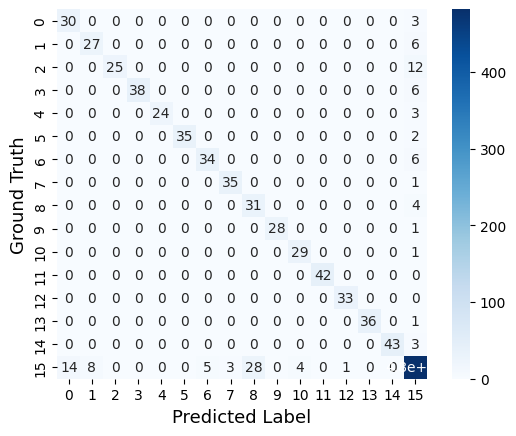

In [347]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(one_hot_labels_list, predicted_lists)
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("Ground Truth", fontsize=13)
plt.savefig('sklearn_confusion_matrix.png')
cm

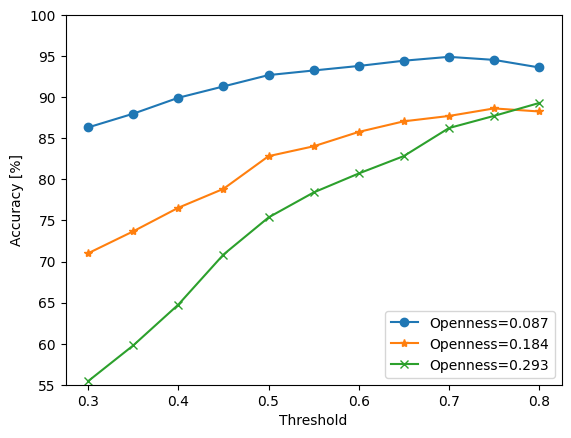

In [354]:
x = np.linspace(0.30, 0.80, 11)
y1 = [86.33, 88.00, 89.94, 91.32, 92.70, 93.26, 93.81, 94.45, 94.92, 94.55, 93.63]
y2 = [71.01, 73.68, 76.55, 78.85, 82.83, 84.03, 85.78, 87.07, 87.72, 88.64, 88.27]
y3 = [55.44, 59.79, 64.76, 70.85, 75.37, 78.41, 80.72, 82.84, 86.25, 87.73, 89.30]
plt.ylim(55, 100)
plt.xlabel("Threshold")
plt.ylabel("Accuracy [%]")
plt.plot(x, y1, marker="o", label="Openness=0.087")
plt.plot(x, y2, marker="*", label="Openness=0.184")
plt.plot(x, y3, marker="x", label="Openness=0.293")
plt.legend()